<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC2_FD003_LSTMv2_optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%pip install scikeras;
%pip install -U tensorflow-addons;
%pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime

H:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
H:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
H:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import GroupKFold

from sklearn.base import BaseEstimator,RegressorMixin

In [4]:
from skopt import BayesSearchCV

from skopt.space.space import Categorical, Integer, Real

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE

from keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow_addons as tfa
from tensorflow_addons.metrics import RSquare as R2

from scikeras.wrappers import KerasRegressor

In [6]:
sns.set_palette('colorblind')

In [7]:
# Reproducibility
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
tf.config.experimental.enable_op_determinism()

In [9]:
# Remove some tf warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Data Preparation

In [10]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    IN_COLAB = True
    folder="/content/"

    # Dataset Download 
    os.system('git clone https://github.com/arthursl12/dataset_2')
    os.system('mv /content/dataset_2/CMaps /content/CMaps')
    os.system('mv /content/dataset_2/data_processing /content/data_processing')
    os.system('rm -rf dataset_2')
else:
    print('Not running on CoLab')
    IN_COLAB = False
    folder="CMaps/"
    %cd dataset_2/

Not running on CoLab
C:\Users\Arthur Lima\POC\dataset_2


In [11]:
from data_processing.processing import DatasetProcessing
from data_processing.training import HyperparameterSearch, reclipper_scorer
from data_processing.eval import Evaluation

In [12]:
proc = DatasetProcessing()

## Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [13]:
index_cols, settings_cols, sensors_cols, cols = proc.column_names()
train, test, y_test = proc.read_dataset(3, folder='CMaps/')
train

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753


## Preprocessing

### Validation Set

In [14]:
from sklearn.model_selection import GroupShuffleSplit

def train_val_split(train):
    gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  
    for idx_train, idx_val in gss.split(train,groups=train["unit_number"]):
        # print('train_split_engines', train.iloc[idx_train]['unit_number'].unique(), '\n')
        # print('validate_split_engines', train.iloc[idx_val]['unit_number'].unique(), '\n')

        df_train = train.iloc[idx_train].copy()
        df_val = train.iloc[idx_val].copy()

    return df_train, df_val

In [15]:
df_train, df_val = train_val_split(train)

In [16]:
X_t_train, y_t_train = proc.X_y_train_divide(df_train)
X_t_val, y_t_val = proc.X_y_train_divide(df_val)

### Test Set Transformation 
Test set has samples for all cycles, but has annotations only for last one

In [17]:
test.shape, y_test.shape

((16596, 26), (100, 1))

In [18]:
test_last = proc.transform_test(test)
test_last.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,642.59,1592.40,1409.87,14.62,21.58,560.53,2388.22,9085.50,1.31,...,528.05,2388.23,8158.77,8.2966,0.03,393,2388,100.0,39.43,23.5679
1,518.67,642.56,1587.42,1409.69,14.62,21.61,553.33,2388.18,9050.97,1.30,...,520.90,2388.17,8128.04,8.4514,0.03,392,2388,100.0,38.83,23.2821
2,518.67,642.75,1591.93,1417.66,14.62,21.60,563.61,2388.31,9091.69,1.31,...,531.36,2388.33,8173.56,8.3057,0.03,395,2388,100.0,39.27,23.6440
3,518.67,642.28,1584.68,1406.56,14.62,21.61,552.75,2388.07,9048.23,1.30,...,521.27,2388.09,8133.78,8.4337,0.03,392,2388,100.0,38.70,23.3804
4,518.67,642.15,1580.59,1397.26,14.62,21.58,553.82,2387.96,9050.89,1.30,...,521.74,2387.96,8132.51,8.3900,0.03,390,2388,100.0,38.89,23.4463


In [19]:
X_test = test_last

### Remaining Useful Life (RUL)

In [20]:
train = proc.add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

,unit_number,time,RUL
0,1,1,258
1,1,2,257
2,1,3,256
3,1,4,255
4,1,5,254


## Attributes and target separation

In [21]:
X_train, y_train = proc.X_y_train_divide(train)

In [22]:
y_train.head()

,RUL
0,258
1,257
2,256
3,255
4,254


In [23]:
X_train.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


## Training and Evaluation functions

In [24]:
eval = Evaluation()

In [25]:
search = HyperparameterSearch()

# LSTM Construction

## Callbacks

In [26]:
# Early Stopping Callback
es = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                      patience=5, restore_best_weights=True)

In [27]:
# Printing Callback
def printLog(epoch, logs):
    print(
        f"E {epoch+1}\t: loss={logs['loss']:.3f}, "+
        f"rmse={logs['root_mean_squared_error']:.3f}, "+
        f"r2={logs['r_square']:.3f}; "+
        f"v_loss={logs['val_loss']:.3f}, "+
        f"v_rmse={logs['val_root_mean_squared_error']:.3f}, "+
        f"v_r2={logs['val_r_square']:.3f}; "
    )

printerCallback = LambdaCallback(on_epoch_end=printLog)

## Constants

In [28]:
# X_train must include indices
train3 = train.copy()
X_train_ = train3.drop(columns=["RUL"])

In [29]:
INPUT_SHAPE = 0

## Wrapper

In [30]:
from sklearn.metrics import r2_score

class LSTMWrapperRegressor(BaseEstimator,RegressorMixin):
    def __init__(self, basemodel=None, clip_y=-1, seq_length=40,
                 include_settings=False, poly_degree=1,
                 scaler=StandardScaler()):
        # Base parameters
        self.basemodel = basemodel
        self.clip_y = clip_y
        self.seq_length = seq_length
        self.poly_degree = poly_degree
        self.include_settings = include_settings

        # Column indexers
        self.feature_cols = sensors_cols
        if(include_settings):
            # self.seq_cols = settings_cols + self.cols
            self.feature_cols = settings_cols + self.feature_cols
        self.seq_cols = ["time"] + self.feature_cols
        self.base_feature_cols = self.feature_cols

        # Scaler and PolyFeatures transformers
        self.scaler = scaler
        self.polyft = PolynomialFeatures(degree=self.poly_degree, 
                                         include_bias=False)



    def fit(self, X=None, y=None):
        # Merge features and target again
        data = X.copy()
        data["RUL"] = y

        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.fit_transform(data[self.base_feature_cols])
        transf = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out(),
                              index=data.index)
        self.feature_cols = list(self.polyft.get_feature_names_out())
        self.seq_cols = ["time"] + self.feature_cols
        data[self.feature_cols] = transf

        # Scale the data
        data[self.feature_cols] = \
                            self.scaler.fit_transform(data[self.feature_cols])

        # Transform into time series
        X_train = self.gen_X_wrapper(data,self.seq_length,self.seq_cols)
        # print(data.shape,X_train.shape, X.shape)

        # Clip and transform labels
        data2 = data.copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_train = self.gen_y_wrapper(data2,self.seq_length,["RUL"])

        # Update input shape for future use
        global INPUT_SHAPE
        # print(INPUT_SHAPE, X_train.shape)
        INPUT_SHAPE = (X_train.shape[1],X_train.shape[2])

        # Fit model
        # print(X_train.shape, y_train.shape)
        self.basemodel.fit(X_train,y_train)
        return self
        
    def predict(self, X=None):
        # Perform transformation, if not done
        if (len(X.shape) < 3):
            data = X.copy()

            # Apply polynomial features
            transf = self.polyft.transform(data[self.base_feature_cols])
            transf = pd.DataFrame(transf, 
                                  columns=self.polyft.get_feature_names_out(),
                                  index=data.index)
            # data = pd.concat([data,transf], axis=1)
            data[self.feature_cols] = transf

            # Scale the data
            data[self.feature_cols] = \
                            self.scaler.transform(data[self.feature_cols])
            
            # Transform into time series
            X_train = self.gen_X_wrapper(data,self.seq_length,self.seq_cols)
        else:
            X_train = X
        return self.basemodel.predict(X_train)

    def score(self, X, y, sample_weight=None):
        # Merge features and target again
        data = X.copy()
        data["RUL"] = y

        # Apply polynomial features
        transf = self.polyft.transform(data[self.base_feature_cols])
        transf = pd.DataFrame(transf, 
                              columns=self.polyft.get_feature_names_out(),
                              index=data.index)
        # data = pd.concat([data,transf], axis=1)
        data[self.feature_cols] = transf

        # Scale the data (with train data parameters)
        data[self.feature_cols] = \
                        self.scaler.transform(data[self.feature_cols])
        
        # Transform into time series
        X_test = self.gen_X_wrapper(data,self.seq_length,self.seq_cols)
        # print(data.shape,X_test.shape, X.shape)

        # Clip and transform labels
        data2 = data.copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_test = self.gen_y_wrapper(data2,self.seq_length,["RUL"])

        # Predict on test data
        y_pred = self.predict(X_test)
        return r2_score(y_test, y_pred, sample_weight=sample_weight)

    def gen_X_data(self, df, sequence_length, columns, mask_value=-99.):
        if df.shape[0] < sequence_length:
            # print("\t Not enough sequence:",df.shape[0]," < ",sequence_length)
            data = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
            idx = data.shape[0] - df.shape[0]
            data[idx:,:] = df[columns].values  # fill with available data
        else:
            data = df[columns].values
            
        # # specifically yield the last possible sequence
        # stop = num_elements = data_matrix.shape[0]
        # start = stop - sequence_length
        # for i in list(range(1)):
        #     yield data_matrix[start:stop, :]



        # data = df[columns].values
        num_elements = data.shape[0]

        # -1 and +1 because of Python indexing
        for start, stop in zip(range(0, num_elements-(sequence_length-1)), 
                               range(sequence_length, num_elements+1)):
            yield data[start:stop, :]

    def gen_X_wrapper(self, df, sequence_length, columns, 
                      unit_nrs=np.array([]), idx_col="unit_number"):
        # print(">> Wrapper called. df shape:",df.shape)
        if unit_nrs.size <= 0:
            unit_nrs = df[idx_col].unique()
            
        data_gen = (list(self.gen_X_data(df[df[idx_col]==unit_nr], 
                                         sequence_length, columns))
                for unit_nr in unit_nrs)
        # print("\tdatagen len:",len(data_gen))
        data_array = np.concatenate(list(data_gen)).astype(np.float32)
        # print("\tdata_array.shape:",data_array.shape)
        return data_array

    def gen_y(self, df, sequence_length, label):
        data_matrix = df[label].values
        num_elements = data_matrix.shape[0]

        # -1 because I want to predict the rul of that last row in the sequence, 
        # not the next row
        return data_matrix[sequence_length-1:num_elements, :]  

    def gen_y_wrapper(self, df, sequence_length, label, 
                      unit_nrs=np.array([]), idx_col="unit_number"):
        # print(">> Y Wrapper called. df shape:",df.shape)
        if unit_nrs.size <= 0:
            unit_nrs = df[idx_col].unique()
            
        label_gen = [self.gen_y(df[df[idx_col]==unit_nr], 
                                sequence_length, label) 
                    for unit_nr in unit_nrs]
        # print("\tlabelgen len:",len(label_gen))
        label_array = np.concatenate(label_gen).astype(np.float32)
        # print("\tlabel_array.shape:",label_array.shape)
        return label_array

## Test Data

In [31]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

In [32]:
def gen_test_wrapper(X_test_scaled, sequence_length, cols, idx_col="unit_number"): 
    data_gen = (
        list(gen_test_data(X_test_scaled[X_test_scaled[idx_col]==unit_nr], 
                           sequence_length, cols, -99.))
            for unit_nr in X_test_scaled[idx_col].unique())
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [33]:
def scale_test(test,model):
    test2 = test.copy()

    # Apply polynomial features
    transf = model.polyft.transform(test2[model.base_feature_cols])
    transf = pd.DataFrame(transf, 
                          columns=model.polyft.get_feature_names_out(),
                          index=test2.index)
    newcols = model.polyft.get_feature_names_out()
    test2[newcols] = transf 

    # Scale the data (with train data parameters)
    test2[model.feature_cols] = \
                    model.scaler.transform(test2[model.feature_cols])
    return test2

## Constructor

In [34]:
def create_model(optim=Adam, learning_rate=1e-3, 
                 layer1=32  , activation1="tanh"    , dropout1=0.1,
                 layer2=None, activation2="tanh"    , dropout2=0.1,
                 layer3=None, activation3="tanh"    , dropout3=0.1,
                 second_dense=True,
                 print_summary=False, loss='mean_squared_error',
                 metrics=[tf.keras.metrics.MeanSquaredError()]):
    model = Sequential()

    # Input-masked layer
    model.add(Masking(mask_value=-99., input_shape=INPUT_SHAPE))
    
    if (layer2 is None and layer3 is None):
        # Single LSTM layer
        model.add(LSTM(layer1, activation=activation1))
        model.add(Dropout(dropout1))
    elif (layer2 is not None and layer3 is None):
        # LSTM-Dense
        model.add(LSTM(layer1, activation=activation1))
        model.add(Dropout(dropout1))
        model.add(Dense(layer2, activation=activation2))
        model.add(Dropout(dropout2))
    elif (layer2 is not None and layer3 is not None and second_dense==False):
        # LSTM-LSTM-Dense
        model.add(LSTM(layer1, activation=activation1, return_sequences=True))
        model.add(Dropout(dropout1))
        model.add(LSTM(layer2, activation=activation2))
        model.add(Dropout(dropout2))
        model.add(Dense(layer3, activation=activation3))
        model.add(Dropout(dropout3))
    elif (layer2 is not None and layer3 is not None and second_dense==True):
        # LSTM-Dense-Dense
        model.add(LSTM(layer1, activation=activation1))
        model.add(Dropout(dropout1))
        model.add(Dense(layer2, activation=activation2))
        model.add(Dropout(dropout2))
        model.add(Dense(layer3, activation=activation3))
        model.add(Dropout(dropout3))

    # Output Layer
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optim(learning_rate=learning_rate), 
                  metrics=metrics)
    
    if(print_summary): model.summary()
    return model

# HyperParameter Tuning

In [35]:
SEQ_LENGTH=79
CLIP=126

model = LSTMWrapperRegressor(
        clip_y=CLIP, seq_length=SEQ_LENGTH,
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=32,
                           epochs=23,
                           validation_split=0.23542211183603107, 
                           model__activation1='tanh',
                           model__dropout1=0.30649418903936865, 
                           model__layer1=512, 
                           model__layer2=64,
                        #    model__activation2='tanh',
                        #    model__dropout2=0.30649418903936865,
                           model__layer3=64,
                        #    model__activation3='tanh',
                        #    model__dropout3=0.30649418903936865,
                           model__learning_rate=0.0010472789501880123,
                           model__second_dense=False,
                           model__optim=RMSprop,
                           verbose=0, callbacks=[es],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=False
                           )
    )

In [36]:
# ~1h LSTM-1
# ~1h30min LSTM-2
GRID_SEARCH = True
if (GRID_SEARCH):
    param_distributions = {
        "seq_length": Integer(30,100),
        "clip_y": Integer(80,140),
        # "poly_degree": Categorical([2,3]),
        "basemodel__model__second_dense": Categorical([False]),
        "scaler": Categorical([MinMaxScaler(),StandardScaler()]),
        "basemodel__epochs": Integer(1,50),
        "basemodel__validation_split":Real(0.1,0.9),
        "basemodel__batch_size": Integer(32,512),
        "basemodel__model__optim":Categorical([Adam,RMSprop]),
        "basemodel__model__learning_rate": Real(1e-4, 1e-2),

        "basemodel__model__layer1": Integer(16,512),
        "basemodel__model__activation1": Categorical(["tanh"]),
        "basemodel__model__dropout1": Real(0.1,0.9),

        "basemodel__model__layer2": Integer(16,512),
        # "basemodel__model__activation2": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__activation2": Categorical(["tanh"]),
        "basemodel__model__dropout2": Real(0.1,0.9),

        "basemodel__model__layer3": Integer(16,512),
        "basemodel__model__activation3": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout3": Real(0.1,0.9),
    }
    gcv = GroupKFold(n_splits=3)
    groups=X_train_['unit_number']
    bss = BayesSearchCV(model, param_distributions, 
                        verbose=3, n_jobs=1, refit=False,
                        cv=gcv.split(X_train_, groups=groups), n_iter=20)
                        # cv=gcv.split(X_train_, groups=groups), n_iter=2)
    
    model = bss.fit(X_train_, y_train)
    
    # print(bss.best_estimator_)
    print("Finished:", datetime.datetime.now())

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END basemodel__batch_size=229, basemodel__epochs=37, basemodel__model__activation1=tanh, basemodel__model__activation2=tanh, basemodel__model__activation3=sigmoid, basemodel__model__dropout1=0.4312949059884308, basemodel__model__dropout2=0.3807450679193153, basemodel__model__dropout3=0.6916033873523364, basemodel__model__layer1=167, basemodel__model__layer2=337, basemodel__model__layer3=289, basemodel__model__learning_rate=0.0013556548021189216, basemodel__model__optim=<class 'keras.optimizer_v2.adam.Adam'>, basemodel__model__second_dense=False, basemodel__validation_split=0.16231298330980526, clip_y=120, scaler=StandardScaler(), seq_length=84;, score=-0.002 total time= 1.3min
[CV 2/3] END basemodel__batch_size=229, basemodel__epochs=37, basemodel__model__activation1=tanh, basemodel__model__activation2=tanh, basemodel__model__activation3=sigmoid, basemodel__model__dropout1=0.4312949059884308, basemodel__model__dropout2

In [37]:
# print(bss.best_estimator_)
print(bss.best_score_)
print(bss.best_params_)
print("Finished:", datetime.datetime.now())

0.9399516883374335
OrderedDict([('basemodel__batch_size', 491), ('basemodel__epochs', 35), ('basemodel__model__activation1', 'tanh'), ('basemodel__model__activation2', 'tanh'), ('basemodel__model__activation3', 'selu'), ('basemodel__model__dropout1', 0.269131429819357), ('basemodel__model__dropout2', 0.1000488406021388), ('basemodel__model__dropout3', 0.3965483901301635), ('basemodel__model__layer1', 311), ('basemodel__model__layer2', 103), ('basemodel__model__layer3', 397), ('basemodel__model__learning_rate', 0.004499578015509351), ('basemodel__model__optim', <class 'keras.optimizer_v2.adam.Adam'>), ('basemodel__model__second_dense', False), ('basemodel__validation_split', 0.3941085696997352), ('clip_y', 104), ('scaler', StandardScaler()), ('seq_length', 97)])
Finished: 2022-10-24 10:06:07.893176


Finished: 2022-10-24 10:06:08.137639


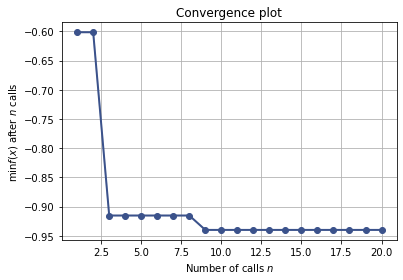

In [38]:
from skopt.plots import plot_convergence

plot_convergence(bss.optimizer_results_)
print("Finished:", datetime.datetime.now())

In [39]:
bss.best_params_

OrderedDict([('basemodel__batch_size', 491),
             ('basemodel__epochs', 35),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'tanh'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__dropout1', 0.269131429819357),
             ('basemodel__model__dropout2', 0.1000488406021388),
             ('basemodel__model__dropout3', 0.3965483901301635),
             ('basemodel__model__layer1', 311),
             ('basemodel__model__layer2', 103),
             ('basemodel__model__layer3', 397),
             ('basemodel__model__learning_rate', 0.004499578015509351),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__model__second_dense', False),
             ('basemodel__validation_split', 0.3941085696997352),
             ('clip_y', 104),
             ('scaler', StandardScaler()),
             ('seq_length', 97)])

# LSTM 1-layer 




## Linear RUL

Score: 0.7960749287247998  
Test: 0.
```
('basemodel__batch_size', 53),
             ('basemodel__epochs', 40),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__dropout1', 0.2519865793617908),
             ('basemodel__model__layer1', 254),
             ('basemodel__model__learning_rate', 0.0026310480233180064),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.268645350331565),
             ('scaler', StandardScaler()),
             ('seq_length', 96)
```



## Non-Linear RUL
Score: 0.9405557989097725  
Test: 0.
```
('basemodel__batch_size', 320),
             ('basemodel__epochs', 50),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__dropout1', 0.1),
             ('basemodel__model__layer1', 171),
             ('basemodel__model__learning_rate', 0.003956355423514566),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.1402058641858904),
             ('clip_y', 81),
             ('scaler', StandardScaler()),
             ('seq_length', 65)
```



# LSTM-Dense-1 




## Linear RUL

Score: 0.7565845071829033  
Test: 0.
```
('basemodel__batch_size', 83),
             ('basemodel__epochs', 31),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__dropout1', 0.24854411808808108),
             ('basemodel__model__dropout2', 0.42830600210145653),
             ('basemodel__model__layer1', 220),
             ('basemodel__model__layer2', 164),
             ('basemodel__model__learning_rate', 0.001141928043462988),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__model__second_dense', True),
             ('basemodel__validation_split', 0.23166030850146868),
             ('scaler', MinMaxScaler()),
             ('seq_length', 73)
```




## Non-Linear RUL
Score: 0.888684501987752  
Test: 0.
```
('basemodel__batch_size', 118),
             ('basemodel__epochs', 30),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__dropout1', 0.8430541193967747),
             ('basemodel__model__dropout2', 0.5945240280760793),
             ('basemodel__model__layer1', 162),
             ('basemodel__model__layer2', 142),
             ('basemodel__model__learning_rate', 0.002503870405609483),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__model__second_dense', True),
             ('basemodel__validation_split', 0.6441614026771669),
             ('clip_y', 83),
             ('scaler', StandardScaler()),
             ('seq_length', 86)
```


# LSTM-Dense-2




## Linear RUL

Score: 0.6493310087734959  
Test: 0.
```
('basemodel__batch_size', 199),
             ('basemodel__epochs', 35),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'relu'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__dropout1', 0.25434586961869254),
             ('basemodel__model__dropout2', 0.16002400441910994),
             ('basemodel__model__dropout3', 0.35413824342558264),
             ('basemodel__model__layer1', 425),
             ('basemodel__model__layer2', 66),
             ('basemodel__model__layer3', 470),
             ('basemodel__model__learning_rate', 0.0032857714954219377),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__model__second_dense', True),
             ('basemodel__validation_split', 0.26624246496701254),
             ('scaler', MinMaxScaler()),
             ('seq_length', 81)
```




## Non-Linear RUL
Score: 0.9051346719630059  
Test: 0.
```
('basemodel__batch_size', 123),
             ('basemodel__epochs', 33),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'tanh'),
             ('basemodel__model__activation3', 'tanh'),
             ('basemodel__model__dropout1', 0.1),
             ('basemodel__model__dropout2', 0.5621274317662914),
             ('basemodel__model__dropout3', 0.20153570533706447),
             ('basemodel__model__layer1', 497),
             ('basemodel__model__layer2', 256),
             ('basemodel__model__layer3', 485),
             ('basemodel__model__learning_rate', 0.00056680506717284),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__model__second_dense', True),
             ('basemodel__validation_split', 0.6912604506849247),
             ('clip_y', 88),
             ('scaler', StandardScaler()),
             ('seq_length', 61)
```


# LSTM-LSTM-Dense




## Linear RUL

Score: 0.8175456691305407  
Test: 0.
```
('basemodel__batch_size', 32),
             ('basemodel__epochs', 50),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'tanh'),
             ('basemodel__model__activation3', 'elu'),
             ('basemodel__model__dropout1', 0.9),
             ('basemodel__model__dropout2', 0.4884546283869159),
             ('basemodel__model__dropout3', 0.1),
             ('basemodel__model__layer1', 512),
             ('basemodel__model__layer2', 41),
             ('basemodel__model__layer3', 154),
             ('basemodel__model__learning_rate', 0.0001),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__model__second_dense', False),
             ('basemodel__validation_split', 0.1),
             ('scaler', StandardScaler()),
             ('seq_length', 100)
```




## Non-Linear RUL 
Score: 0.9399516883374335  
Test: 0.
```
('basemodel__batch_size', 491),
             ('basemodel__epochs', 35),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'tanh'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__dropout1', 0.269131429819357),
             ('basemodel__model__dropout2', 0.1000488406021388),
             ('basemodel__model__dropout3', 0.3965483901301635),
             ('basemodel__model__layer1', 311),
             ('basemodel__model__layer2', 103),
             ('basemodel__model__layer3', 397),
             ('basemodel__model__learning_rate', 0.004499578015509351),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__model__second_dense', False),
             ('basemodel__validation_split', 0.3941085696997352),
             ('clip_y', 104),
             ('scaler', StandardScaler()),
             ('seq_length', 97)
```


# LSTM Tester

In [ ]:
SEQ_LENGTH=68
CLIP=105

model = LSTMWrapperRegressor(
        clip_y=CLIP, seq_length=SEQ_LENGTH, scaler=MinMaxScaler(),
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=32,
                           epochs=50,
                           model__activation='tanh',
                           model__dropout=0.1, 
                           model__layer1=512, 
                           model__learning_rate=0.0001,
                           model__optim=Adam,
                           validation_split=0.1, 
                           verbose=0, callbacks=[es, printerCallback],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=True
                           )
    )

In [ ]:
model.fit(X_train_, y_train)

TypeError: ignored

In [ ]:
# Scaling and formatting test data
test_sc = scale_test(test,model)
test_wr = gen_test_wrapper(test_sc, SEQ_LENGTH, cols=model.seq_cols)

# Clipping test labels
reclipped_y = y_test.copy()
# reclipped_y["RUL"].clip(upper=CLIP, inplace=True)

# Evaluation
eval.show_result(reclipped_y, model.basemodel.predict(test_wr))
print("Finished:", datetime.datetime.now())

R2=0.857,RMSE=-15.701
Finished: 2022-10-10 12:37:52.380820


# OFF
## Non-Linear RUL



```
LSTMWrapperRegressor(
    basemodel=KerasRegressor(
        batch_size=32, 
        epochs=23, 
        model__activation='tanh',
        model__dropout=0.30649418903936865, 
        model__layer_nodes=512, 
        model__learning_rate=0.0010472789501880123,
        model__optim=<class 'keras.optimizer_v2.rmsprop.RMSprop'>,
        validation_split=0.23542211183603107,
    clip_y=99, 
    seq_length=79)
```



In [ ]:
def create_model2(optim=Adam, dropout=0.1, activation="tanh", 
                 learning_rate=1e-3, layer1=32, layer2=None, layer3=None,
                 print_summary=False, loss='mean_squared_error',
                 metrics=[tf.keras.metrics.MeanSquaredError()]):
    model = Sequential()

    # Input-masked layer
    model.add(Masking(mask_value=-99., input_shape=INPUT_SHAPE))
    
    if (layer2 is None and layer3 is None):
        # Single LSTM layer
        model.add(LSTM(layer1, activation=activation))
        model.add(Dropout(dropout))
    elif (layer2 is not None and layer3 is None):
        # 2 stacked LSTM layers
        model.add(LSTM(layer1, activation=activation))
        model.add(Dropout(dropout))
        model.add(Dense(layer2, activation=activation))
        model.add(Dropout(dropout))
    elif (layer2 is not None and layer3 is not None):
        # 3 stacked LSTM layers
        model.add(LSTM(layer1, return_sequences=True, activation=activation))
        model.add(Dropout(dropout))
        model.add(Dense(layer2, activation=activation))
        model.add(Dropout(dropout))
        model.add(Dense(layer3, activation=activation))
        model.add(Dropout(dropout))

    # Output Layer
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optim(learning_rate=learning_rate), 
                  metrics=metrics)
    
    if(print_summary): model.summary()
    return model

In [ ]:
SEQ_LENGTH=79
CLIP=99

model = LSTMWrapperRegressor(
        clip_y=CLIP, seq_length=SEQ_LENGTH, poly_degree=1,
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=32,
                           epochs=23,
                           validation_split=0.23542211183603107, 
                           
                           
                           model__layer1=512, 
                           model__activation1='tanh',
                           model__dropout1=0.30649418903936865, 
                           model__layer2=400,
                           model__activation2='selu',
                           model__dropout2=0.30649418903936865,

                        
                           
                           model__learning_rate=0.0010472789501880123,
                           model__optim=RMSprop,
                           verbose=0, callbacks=[es, printerCallback],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=True
                           )
    )

In [ ]:
model.fit(X_train_, y_train)

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_65 (Masking)        (None, 79, 22)            0         
                                                                 
 lstm_65 (LSTM)              (None, 512)               1095680   
                                                                 
 dropout_128 (Dropout)       (None, 512)               0         
                                                                 
 dense_128 (Dense)           (None, 400)               205200    
                                                                 
 dropout_129 (Dropout)       (None, 400)               0         
                                                                 
 dense_129 (Dense)           (None, 1)                 401       
                                                                 
Total params: 1,301,281
Trainable params: 1,301,281
N

KeyboardInterrupt: ignored

In [ ]:
# Scaling and formatting test data
test_sc = scale_test(test,model)
test_wr = gen_test_wrapper(test_sc, SEQ_LENGTH, cols=model.seq_cols)

# Clipping test labels
reclipped_y = y_test.copy()
reclipped_y["RUL"].clip(upper=CLIP, inplace=True)

# Evaluation
eval.show_result(reclipped_y, model.basemodel.predict(test_wr))
print("Finished:", datetime.datetime.now())

R2=0.918,RMSE=-9.668
Finished: 2022-10-13 13:15:58.111062
